# Raw Data Mining

In this file, I will find some patterns from raw traffic data and do some preparision for the following forecasting.

## Packages

1. The package of geopandas is installed by the conda forge. conda install -c conda-forge geopandas

In [1]:
import os
import json

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import folium

import networkx as nx

## Data Path

In [2]:
DATA_ROOT = os.getcwd()
GEO_PATH = os.path.join(DATA_ROOT, 'GeoLinkData.geojson')
# GEO_PATH2 = os.path.join(DATA_ROOT, 'road_network_data')
RAW_TRAFFIC_PATH = os.path.join(DATA_ROOT, 'raw_data_2000000.json')

## Geo Analysis

In [3]:
geo_df = gpd.read_file(GEO_PATH)

In [4]:
geo_df.head()

minimum_tt trend excluded_source_id_types  \
0         126  None                     None   
1          42  None                     None   
2          30  None                     None   
3          68  None                     None   
4          69  None                     None   

                                        latest_stats  \
0  {'excess_delay': -16, 'speed': 51, 'score': 0,...   
1  {'excess_delay': 0, 'speed': 59, 'score': 0, '...   
2  {'excess_delay': -2, 'speed': 67, 'score': 0, ...   
3  {'excess_delay': 1, 'speed': 59, 'score': 0, '...   
4  {'excess_delay': -23, 'speed': 60, 'score': 0,...   

                                            name  \
0       Bulleen Rd, Eastern Fwy to Manningham Rd   
1          Greensborough Hwy, M80 to Grimshaw St   
2          Greensborough Hwy, Grimshaw St to M80   
3  Greensborough Hwy, Grimshaw St to Watsonia Rd   
4  Greensborough Hwy, Watsonia Rd to Grimshaw St   

                                         destination  length  \
0  {'id': 686, 'href': 'https://data-exchange-api...    2000   
1  {'id': 4187, 'href': 'https://data-exchange-ap...    1100   
2  {'id': 3357, 'href': 'https://data-exchange-ap...    1100   
3  {'id': 3341, 'href': 'https://data-exchange-ap...    1400   
4  {'id': 4187, 'href': 'https://data-exchange-ap...    1400   

  closed_or_ignored emulated_travel_time link_params  \
0              None                 None        None   
1              None                 None        None   
2              None                 None        None   
3              None                 None        None   
4              None                 None        None   

                                                href  \
0  https://data-exchange-api.vicroads.vic.gov.au/...   
1  https://data-exchange-api.vicroads.vic.gov.au/...   
2  https://data-exchange-api.vicroads.vic.gov.au/...   
3  https://data-exchange-api.vicroads.vic.gov.au/...   
4  https://data-exchange-api.vicroads.vic.gov.au/...   

                                        organization direction  enabled  \
0  {'id': 1, 'href': 'https://data-exchange-api.v...        NB     True   
1  {'id': 1, 'href': 'https://data-exchange-api.v...        SB     True   
2  {'id': 1, 'href': 'https://data-exchange-api.v...        NB     True   
3  {'id': 1, 'href': 'https://data-exchange-api.v...        SB     True   
4  {'id': 1, 'href': 'https://data-exchange-api.v...        NB     True   

   min_number_of_lanes  is_freeway  id  \
0                    1       False   3   
1                    1       False   5   
2                    1       False   6   
3                    1       False   7   
4                    1       False   8   

                                              origin  \
0  {'id': 2827, 'href': 'https://data-exchange-ap...   
1  {'id': 3357, 'href': 'https://data-exchange-ap...   
2  {'id': 4187, 'href': 'https://data-exchange-ap...   
3  {'id': 4187, 'href': 'https://data-exchange-ap...   
4  {'id': 3341, 'href': 'https://data-exchange-ap...   

                                            geometry  
0  LINESTRING (145.07840 -37.77962, 145.07848 -37...  
1  LINESTRING (145.09357 -37.69418, 145.09332 -37...  
2  LINESTRING (145.08958 -37.70316, 145.08963 -37...  
3  LINESTRING (145.09003 -37.70324, 145.08981 -37...  
4  LINESTRING (145.08263 -37.71442, 145.08276 -37...

In [5]:
with open(GEO_PATH) as f:
    melb_geo_json = json.load(f)

melb_map = folium.Map(location=[-37.840935, 144.946457], zoom_start=10, tiles='Stamen Toner')

folium.GeoJson(melb_geo_json, name='Road Network', 
               style_function=lambda feature: {'color': 'blue',
                                               'weight': 0.5,
                                              }).add_to(melb_map)
folium.LayerControl().add_to(melb_map)
melb_map

### Attributes

In [6]:
geo_df.columns

Index(['minimum_tt', 'trend', 'excluded_source_id_types', 'latest_stats',
       'name', 'destination', 'length', 'closed_or_ignored',
       'emulated_travel_time', 'link_params', 'href', 'organization',
       'direction', 'enabled', 'min_number_of_lanes', 'is_freeway', 'id',
       'origin', 'geometry'],
      dtype='object')

<center>Table 1 Atrributes in Raw Geo Data</center>

|Attributes|Description|Type|
|-|-|-|
|minimum_tt|Free speed|Int|
|Trend|Not sure|Not sure|
|excluded_source_id_types|Not sure|Not sure|
|latest_stats|Stats of Traffic Condition|dict|
|name|Road name|String|
|destination|Infomation of destination of link|dict|
|length|Length of link|Int|
|closed_or_ignored|Not sure|Not sure|
|emulated_travel_time|Not sure|Not sure|
|link_params|Not sure|Not sure|
|href|href of link|String|
|organization|href of responsible department?|String|
|direction|Direction of link|String|
|enabled|Still working|Bool|
|min_number_of_lanes|number of lane of link|Int|
|is_freeway|Whether the link is freeway|Bool|
|id|ID of link|Int|
|origin|Infomation of origin of link|dict|
|geometry|Collection of coordinates of links|List|

#### None Attribtues

In [7]:
# Check whether those attributes with many None values in the head are all None.
def check_none_in_geo():
    potential_columns = ['trend', 'excluded_source_id_types', 'closed_or_ignored', 
                         'emulated_travel_time', 'link_params']
    res = []
    for i in potential_columns:
        value_counts = len(geo_df[i].value_counts())
        print('Unique value counts in {}: {}'.format(i, value_counts))
        if value_counts == 0:
            res.append(i)
    print('-----------------------------------------')
    print('Columns: {} should be remove'.format(res))
    return res

In [8]:
geo_df.drop(columns=check_none_in_geo(), inplace=True)

Unique value counts in trend: 0
Unique value counts in excluded_source_id_types: 0
Unique value counts in closed_or_ignored: 0
Unique value counts in emulated_travel_time: 0
Unique value counts in link_params: 0
-----------------------------------------
Columns: ['trend', 'excluded_source_id_types', 'closed_or_ignored', 'emulated_travel_time', 'link_params'] should be remove


#### Extract Origin and Destination

In [9]:
def extract_link_od(row):
    row['origin'] = row['origin']['id']
    row['destination'] = row['destination']['id']
    return row

geo_df = geo_df.apply(extract_link_od, axis=1)

#### Remove Useless in Road DataFrame

The **latest_stats**, **href**, **organization** in the road network data is not useful. We just want the information related to links. Also, the all values of **enabled** is True. We will remove these three attributes.

In [10]:
geo_df.drop(columns=['latest_stats', 'href', 'enabled'], inplace=True)

#### Final Dataframe of Road Network

In [11]:
# Reorder the dataframe
geo_df = geo_df[['id', 'origin', 'destination', 'minimum_tt', 'length', 
                 'min_number_of_lanes', 'is_freeway','direction', 'name', 'geometry']]

# Convert bool to int
geo_df['is_freeway'] = geo_df['is_freeway'].astype(int)
geo_df

id  origin  destination  minimum_tt  length  min_number_of_lanes  \
0        3    2827          686         126    2000                    1   
1        5    3357         4187          42    1100                    1   
2        6    4187         3357          30    1100                    1   
3        7    4187         3341          68    1400                    1   
4        8    3341         4187          69    1400                    1   
...    ...     ...          ...         ...     ...                  ...   
3859  4617   31580        31050        1672   11613                    1   
3860  4618    2789        31579         265    1846                    1   
3861  4619    2765         3742          58     854                    1   
3862  4620    3742         2765          59     854                    1   
3863  4621    3360         1257          86    1335                    1   

      is_freeway direction                                               name  \
0              0        NB           Bulleen Rd, Eastern Fwy to Manningham Rd   
1              0        SB              Greensborough Hwy, M80 to Grimshaw St   
2              0        NB              Greensborough Hwy, Grimshaw St to M80   
3              0        SB      Greensborough Hwy, Grimshaw St to Watsonia Rd   
4              0        NB      Greensborough Hwy, Watsonia Rd to Grimshaw St   
...          ...       ...                                                ...   
3859           0        WB  DEM Hume - Tulla Fwy , Hume Fwy SB M80 split t...   
3860           1        WB  DEM Hume FWY, MRR Edgars Rd to Hume Fwy NB M80...   
3861           0        WB  DEM Wood St - Dalton Rd, Settlement Rd to Keon...   
3862           0        NB  DEM Dalton Rd - Wood St, Keon Pde to Settlemen...   
3863           0        SB    DEM Lower heidelberg Rd, Banksia St to Burke rd   

                                               geometry  
0     LINESTRING (145.07840 -37.77962, 145.07848 -37...  
1     LINESTRING (145.09357 -37.69418, 145.09332 -37...  
2     LINESTRING (145.08958 -37.70316, 145.08963 -37...  
3     LINESTRING (145.09003 -37.70324, 145.08981 -37...  
4     LINESTRING (145.08263 -37.71442, 145.08276 -37...  
...                                                 ...  
3859  LINESTRING (144.98665 -37.68776, 144.98673 -37...  
3860  LINESTRING (145.00249 -37.68740, 144.99854 -37...  
3861  LINESTRING (145.02982 -37.69365, 145.02502 -37...  
3862  LINESTRING (145.02211 -37.69599, 145.02240 -37...  
3863  LINESTRING (145.06928 -37.75976, 145.06906 -37...  

[3864 rows x 10 columns]

#### Value Description

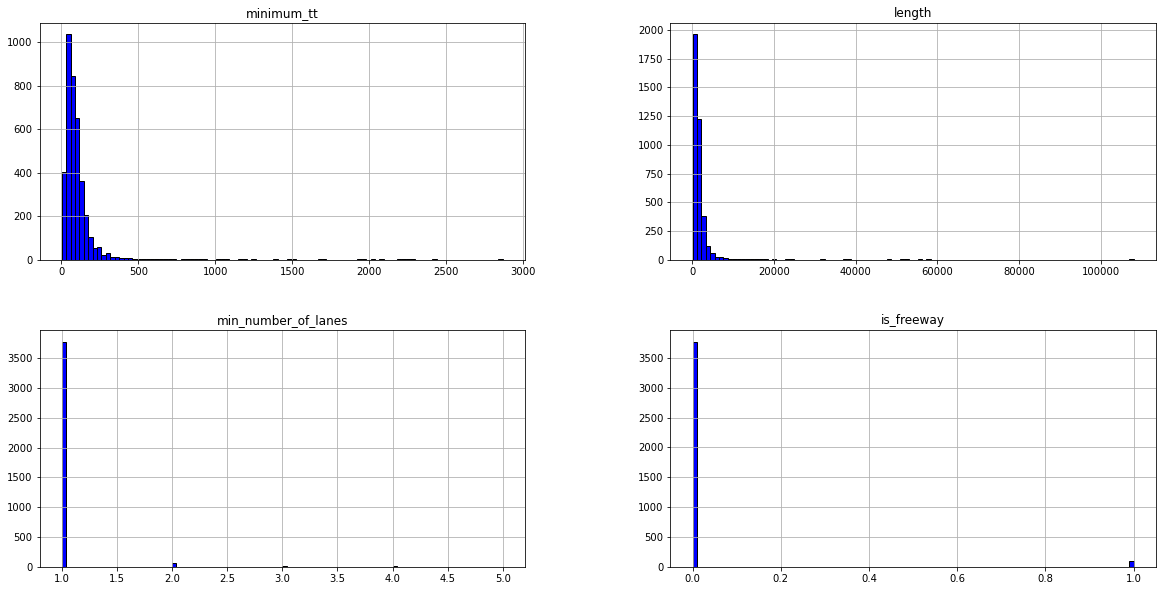

minimum_tt         length  min_number_of_lanes   is_freeway
count  3864.000000    3864.000000          3864.000000  3864.000000
mean    106.180124    1879.822205             1.035197     0.023810
std     165.914891    4377.299995             0.271721     0.152475
min       3.000000     106.000000             1.000000     0.000000
25%      49.000000     714.500000             1.000000     0.000000
50%      76.000000    1163.000000             1.000000     0.000000
75%     116.000000    1855.000000             1.000000     0.000000
max    2867.000000  108077.000000             5.000000     1.000000

In [12]:
geo_df[['minimum_tt', 'length', 'min_number_of_lanes', 'is_freeway']].hist(bins=100, color='blue', 
                                                                           edgecolor='black', figsize=(20, 10))
plt.show()

geo_df[['minimum_tt', 'length', 'min_number_of_lanes', 'is_freeway']].describe()

### Road Network Topology

#### Create Road Graph Based on networkx

In [13]:
road_graph = nx.DiGraph()
for idx, row in geo_df.iterrows():
#     edge_attr = {'minimum_tt': row['minimum_tt'], 'length': row['length'], 
#                  'min_number_of_lanes': row['min_number_of_lanes'], 'is_freeway': row['is_freeway']}
    edge_attr = row.to_dict()
    road_graph.add_edge(row['origin'], row['destination'], attr=edge_attr)

#### Check the Validation of Graph

In [14]:
def check_graph():
    if len(geo_df) != road_graph.number_of_edges():
        print('The number of edges is wrong')
    
    df_node_num = len(set(geo_df['origin'].to_list() + geo_df['destination'].to_list()))
    if df_node_num != road_graph.number_of_nodes():
        print('The number of nodes is wrong')
    
    for idx, row in geo_df.iterrows():
        if road_graph[row['origin']][row['destination']]['attr'] != row.to_dict():
            print('The attrbute of link {} is wrong'.format(row['id']))
            break
    
    print('The process of checking validation of graph is completed!')

check_graph()

The process of checking validation of graph is completed!


#### Graph Description

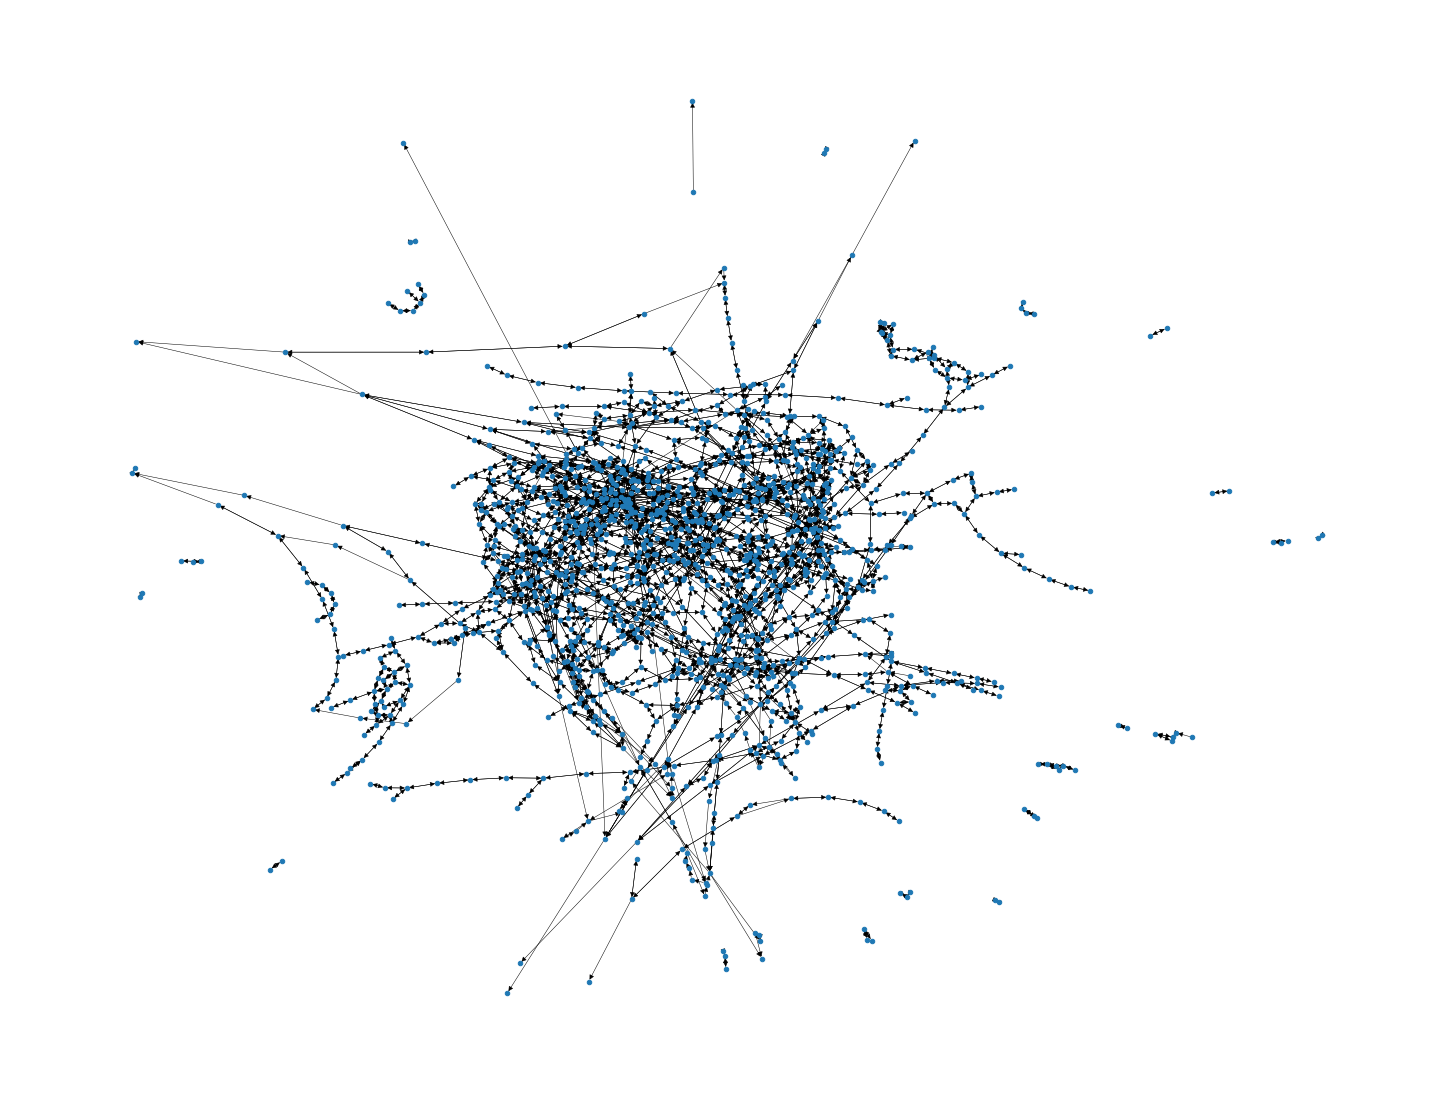

In [23]:
plt.figure(figsize=(20,15))
nx.draw(road_graph, node_size=20, width=0.5, pos=nx.spring_layout(road_graph))
plt.show()

## Traffic Analysis

In [ ]:
# with open(RAW_TRAFFIC_PATH) as f:
#     raw_traffic = json.load(f)
# raw_traffic[0]